# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [124]:
# Enter your information here
first_and_last_name = 'Reza Ghorbani Paji'
std_number = '403206565'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [11]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [13]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mu = np.mean(x, axis=0)
    var = np.var(x, axis=0)

    x_normalized = (x - mu) / np.sqrt(var + epsilon)

    y = gamma * x_normalized + beta

    return y


In [14]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [15]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

train_subset = Subset(train_set, range(len(train_set) // 2))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=False)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

val_loader = DataLoader(val_set, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_set.data.shape

(50000, 32, 32, 3)

In [17]:
train_subset.dataset.data.shape

(50000, 32, 32, 3)

Explain what we did in transfor train and tranform test:<br/>
RandomResizedCrop: Randomly crops a region of the image and resizes it to the target size (224x224 pixels in this case).

RandomHorizontalFlip:Randomly flips the image horizontally with a probability of 50%.

ToTensor:Converts the image to a PyTorch tensor.

Normalize: Normalizes each channel of the image by subtracting the mean and dividing by the standard deviation.


Resize: Resizes the image to the specified target size (224x224 pixels in this case).


for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

Files already downloaded and verified


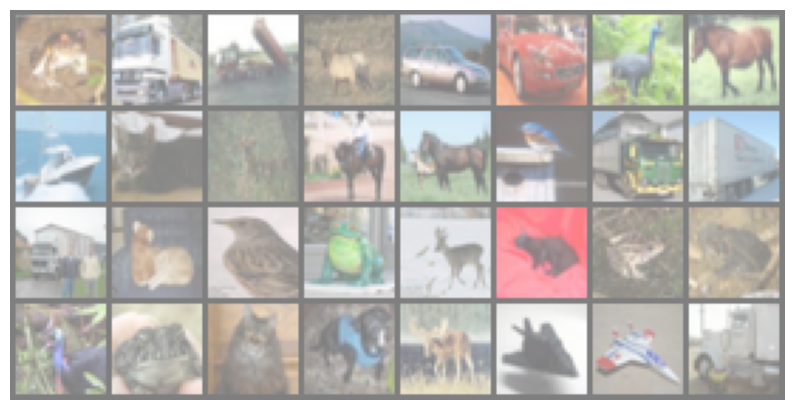

Labels of the first batch of images: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


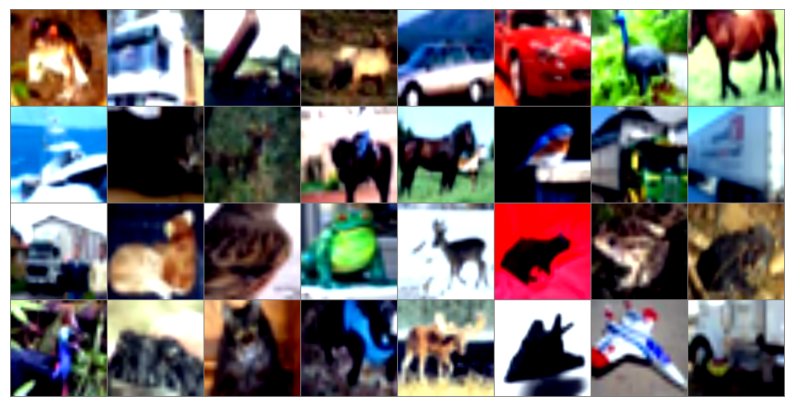

In [18]:
def imshow(img):
    """
    Displays a batch of images in a grid format.
    """
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# show some training images with shuffle=False and labels

train_set_no_shuffle = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
train_loader_no_shuffle = DataLoader(train_set_no_shuffle, batch_size=32, shuffle=False)

data_iter = iter(train_loader_no_shuffle)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print("Labels of the first batch of images:", labels)

# show them again to check the augmentation
train_loader_no_shuffle_augment = DataLoader(train_subset, batch_size=32, shuffle=False)
data_iter = iter(train_loader_no_shuffle_augment)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))

# create train loader with shuffle true
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [20]:

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> Tuple[List[float], float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        Tuple[List[float], float]: A tuple containing the list of batch losses and, if validation, the accuracy.
    """
    model.train() if train_mode else model.eval()

    losses = []
    correct = 0
    total = 0

    for inputs, labels in tqdm(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        if not train_mode:
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(loss.item())

    accuracy = correct / total if total > 0 else 0.0
    return losses, accuracy


def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    lr: float = 1e-3,
    epochs: int = 10
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch, printing loss and accuracy.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses and validation accuracies.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, val_accuracies = [], [], []
    train_loss_sample, val_loss_sample =[], []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        train_loss, _ = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_loss_sample.append(train_loss)
        train_losses.append(np.mean(train_loss))

        val_loss, val_accuracy = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_loss_sample.append(val_loss)
        val_losses.append(np.mean(val_loss))
        val_accuracies.append(val_accuracy)

        print(f"Training Loss: {np.mean(train_loss):.4f} | Validation Loss: {np.mean(val_loss):.4f} | Validation Accuracy: {val_accuracy*100:.2f}%")

    return train_loss_sample ,val_losses, val_accuracies


def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10,
    epochs = 2
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    train_losses = np.array(train_losses).flatten()
    val_losses = np.array(val_losses)

    val_position = []
    for i in range(epochs):
        val_position.append((i+1) * len(train_loader))
    # Smooth the training losses with a moving average
    smooth_train_losses = np.convolve(train_losses, np.ones(c_window)/c_window, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(smooth_train_losses, label='Training Loss')
    plt.plot(val_position,val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [40]:
def conv_bn(inp, oup, stride):
    """
    Defines a standard convolutional layer with batch normalization and ReLU activation.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


def conv_dw(inp, oup, stride):
    """
    Defines a depthwise separable convolutional layer.
    Consists of a depthwise convolution followed by a pointwise convolution.
    Each is followed by batch normalization and ReLU activation.
    """
    return nn.Sequential(

        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU6(inplace=True),

        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


Depthwise separable convolutions reduce the number of parameters by breaking the standard convolution into two smaller operations:

Depthwise convolution: Each input channel gets its own filter, reducing the number of parameters.

Pointwise convolution (1x1): Combines the outputs of the depthwise convolution.

This reduces the number of parameters and computations, making the model faster and more efficient, especially on mobile or embedded devices with limited processing power.

Now please create your model.

In [41]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super(MobileNet, self).__init__()


        self.features = nn.Sequential(
            conv_bn(3, 32, stride=2),
            conv_dw(32, 64, stride=1),
            conv_dw(64, 128, stride=2),
            conv_dw(128, 128, stride=1),
            conv_dw(128, 256, stride=2),
            conv_dw(256, 256, stride=1),
            conv_dw(256, 512, stride=2),

            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),

            conv_dw(512, 1024, stride=2),
            conv_dw(1024, 1024, stride=1)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


In [42]:
model_MobileNet = MobileNet(10).to(device)

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [147]:
epochs = 10
lr = 1e-3

start_time = time.time()

train_losses, val_losses, _ = train(train_loader, val_loader, model_MobileNet, lr, epochs)


training_time = time.time() - start_time

print(f'Training time: {training_time:.2f} seconds')

Epoch 1/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.7254 | Validation Loss: 1.7803 | Validation Accuracy: 38.56%
Epoch 2/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.3227 | Validation Loss: 1.2539 | Validation Accuracy: 55.09%
Epoch 3/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.1440 | Validation Loss: 1.1363 | Validation Accuracy: 59.53%
Epoch 4/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.0160 | Validation Loss: 1.1386 | Validation Accuracy: 61.74%
Epoch 5/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.9135 | Validation Loss: 0.8709 | Validation Accuracy: 68.96%
Epoch 6/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.8139 | Validation Loss: 0.7543 | Validation Accuracy: 73.66%
Epoch 7/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.7414 | Validation Loss: 0.7501 | Validation Accuracy: 73.78%
Epoch 8/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.6897 | Validation Loss: 0.6673 | Validation Accuracy: 76.97%
Epoch 9/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.6325 | Validation Loss: 0.6979 | Validation Accuracy: 76.54%
Epoch 10/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.5901 | Validation Loss: 0.6653 | Validation Accuracy: 78.03%
Training time: 1466.82 seconds


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7803
Process validation time: 22.3042 s


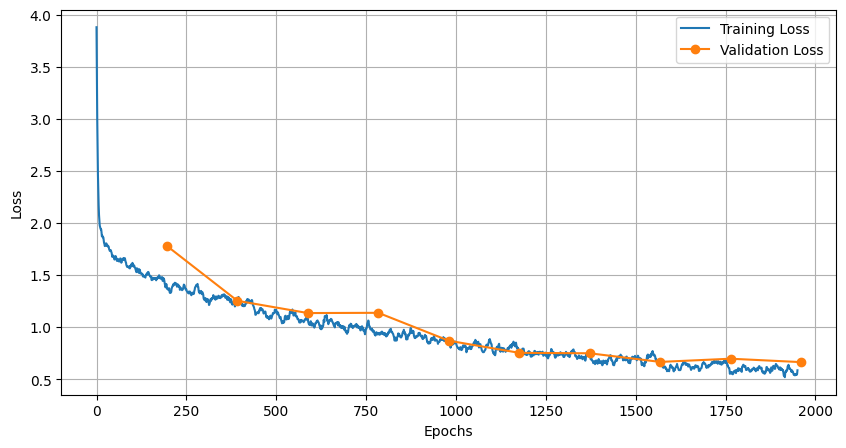

In [148]:
start = time.time()
val_acc = get_acc(model_MobileNet, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses,epochs=epochs)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.

The MobileNet paper claims that depthwise separable convolution (DSC) is 8 to 9 times faster than standard convolution due to the significant reduction in FLOPs (floating-point operations).

In standard convolution, the number of FLOPs is proportional to the number of input channels, output channels, and the size of the kernel. In contrast, depthwise separable convolution breaks this down into two steps: first, applying a depthwise convolution that processes each input channel independently, and second, applying a pointwise convolution that combines the results of the depthwise step. 

This decomposition reduces the number of computations needed by eliminating the need for a f$l \(C_{\text{in}} \times C_{\text{o$}}\) computation for each pixel, resulting in a much lower computational cost. As a result, depthwise separable convolution is typically 8 to 9 times more efficient than standard convolution, especially in mobile or resource-constrained environments.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [24]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [25]:
model_CNN = NormalCNN(n_class=10).to(device)

In [151]:
epochs = 2
lr = 1e-3
train_losses,val_losses,_ = train(train_loader, val_loader,model_CNN, lr, epochs=epochs)

Epoch 1/2


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.9543 | Validation Loss: 1.9983 | Validation Accuracy: 25.77%
Epoch 2/2


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.7118 | Validation Loss: 1.6254 | Validation Accuracy: 39.41%


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.3941
Process validation time: 32.1597 s


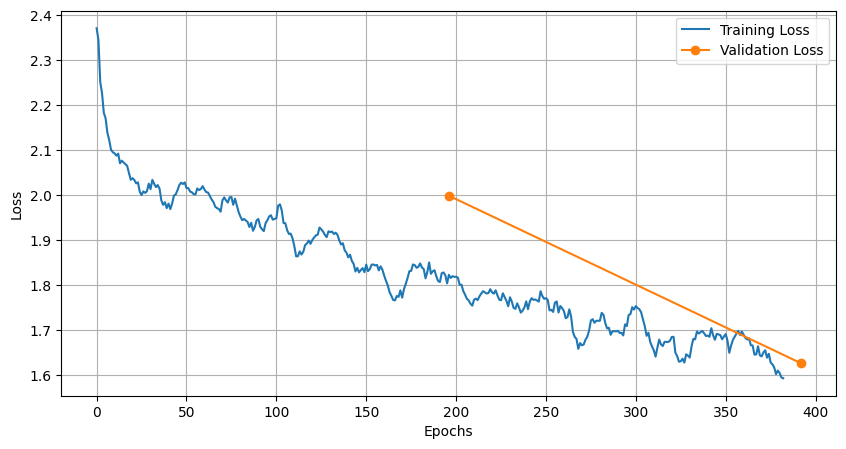

In [153]:
start = time.time()
val_acc = get_acc(model_CNN, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

batches_per_epoch = len(train_loader)
plot_losses(train_losses, val_losses,epochs=epochs)

Compare speed of learning and validating in normal CNN vs MobileNet

MobileNet is designed to be more efficient and lightweight compared to a normal CNN, so it will generally have faster validation and learning speeds, especially on larger datasets. This is due to the use of depthwise separable convolutions in MobileNet, which reduces the computational cost while maintaining good performance. On the other hand, a normal CNN (like the one in your code) may require more resources and time to train and validate due to its heavier architecture.

In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

normal_cnn_params = count_parameters(model_CNN)
mobilenet_params = count_parameters(model_MobileNet)

print(f"Total number of normal CNN parameters: {normal_cnn_params}")
print(f"Total number of normal MobileNet parameters: {mobilenet_params}")


Total number of normal CNN parameters: 28279338
Total number of normal MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [46]:
model = MobileNet(n_class=100).to(device)

pretrained_weights = torch.load('/kaggle/input/2/pytorch/default/1/model.pt')


filtered_weights = {
    k: v
    for k, v in pretrained_weights.items()
    if k in model.state_dict()
    and k not in ["linear.weight", "linear.bias", "fc.weight", "fc.bias"]
}

model.load_state_dict(filtered_weights, strict=False)

/tmp/ipykernel_23/2171275399.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load('/kaggle/input/2/pytorch/default/1/model.pt')


_IncompatibleKeys(missing_keys=['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.1.0.weight', 'features.1.1.weight', 'features.1.1.bias', 'features.1.1.running_mean', 'features.1.1.running_var', 'features.1.3.weight', 'features.1.4.weight', 'features.1.4.bias', 'features.1.4.running_mean', 'features.1.4.running_var', 'features.2.0.weight', 'features.2.1.weight', 'features.2.1.bias', 'features.2.1.running_mean', 'features.2.1.running_var', 'features.2.3.weight', 'features.2.4.weight', 'features.2.4.bias', 'features.2.4.running_mean', 'features.2.4.running_var', 'features.3.0.weight', 'features.3.1.weight', 'features.3.1.bias', 'features.3.1.running_mean', 'features.3.1.running_var', 'features.3.3.weight', 'features.3.4.weight', 'features.3.4.bias', 'features.3.4.running_mean', 'features.3.4.running_var', 'features.4.0.weight', 'features.4.1.weight', 'features.4.1.bias', 'features.4.1.running_mean', 'fea

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [47]:
for i in list(model.parameters())[:7]:
    i.requires_grad = False

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [48]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169001437/169001437 [00:06<00:00, 25605509.12it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

Files already downloaded and verified


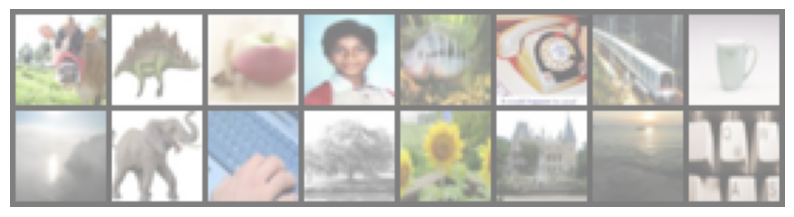

Labels are: tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39])
Files already downloaded and verified


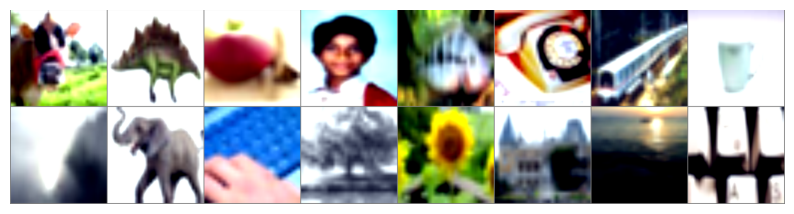

In [49]:
def imshow(img):
    """
    Displays a batch of images in a grid format.
    """
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


train_set_no_shuffle = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader_no_shuffle = DataLoader(train_set_no_shuffle, batch_size=16, shuffle=False)

data_iter = iter(train_loader_no_shuffle)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print("Labels are:", labels)

train_set_with_augment = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_loader_with_augment = DataLoader(train_set_with_augment, batch_size=16, shuffle=False)

data_iter = iter(train_loader_with_augment)
images, labels = next(data_iter)

# Display the images after augmentation
imshow(torchvision.utils.make_grid(images))

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

CIFAR-10 and CIFAR-100 do not use the same images. They are separate datasets with different sets of images and class labels. CIFAR-10 has 10 classes, while CIFAR-100 has 100 classes, with the latter being more fine-grained.









Now train your model using your functions.

In [50]:
epochs = 7
lr = 2e-4
model = model.to(device)
train_losses, val_losses, _ = train(train_loader100, val_loader100, model, lr, epochs)

Epoch 1/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 4.3680 | Validation Loss: 4.1497 | Validation Accuracy: 5.86%
Epoch 2/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 3.8825 | Validation Loss: 3.8880 | Validation Accuracy: 10.05%
Epoch 3/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 3.6268 | Validation Loss: 3.6269 | Validation Accuracy: 13.64%
Epoch 4/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 3.4283 | Validation Loss: 3.4381 | Validation Accuracy: 16.92%
Epoch 5/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 3.2599 | Validation Loss: 3.2827 | Validation Accuracy: 20.39%
Epoch 6/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 3.1074 | Validation Loss: 3.1585 | Validation Accuracy: 21.80%
Epoch 7/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 2.9788 | Validation Loss: 3.1809 | Validation Accuracy: 22.13%


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.2213
Process validation time: 13.3123 s


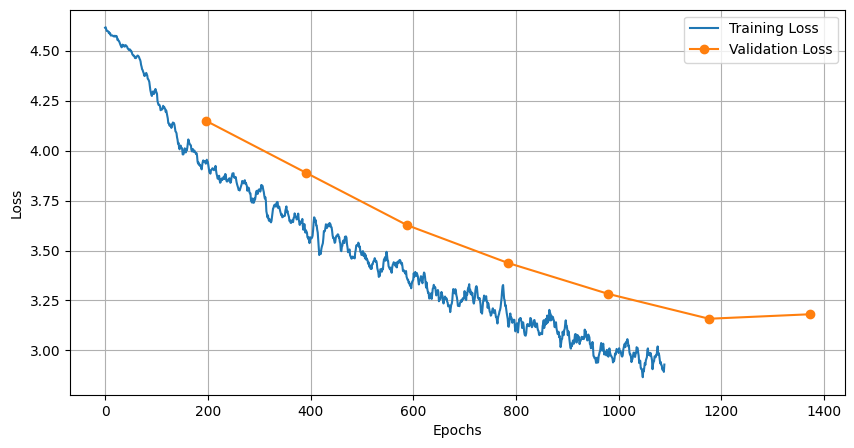

In [51]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses,epochs = epochs)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

**What** is ReLU6 Activation Function? Why do we use that?

**ReLU6** is a variant of the ReLU activation function that caps the output at 6. It is defined as:

ReLU6(x) = min(max(0, x), 6)


It is used in lightweight models like **MobileNets** for better stability, efficient computation, and compatibility with **quantization** in resource-constrained environments. The cap at 6 helps prevent excessively large activations, making it easier to implement on hardware with limited precision.

In [62]:

def conv_bn(inp, oup, stride):
    """
    Creates a convolutional layer followed by batch normalization and ReLU6 activation.

    Parameters:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the convolution.

    Returns:
        nn.Sequential: A sequential container of Conv2d, BatchNorm2d, and ReLU6 layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    """
    Creates a 1x1 convolutional layer followed by batch normalization and ReLU6 activation.

    Parameters:
        inp (int): Number of input channels.
        oup (int): Number of output channels.

    Returns:
        nn.Sequential: A sequential container of Conv2d, BatchNorm2d, and ReLU6 layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        """
        Inverted Residual block with optional skip connection.

        Parameters:
            inp (int): Number of input channels.
            oup (int): Number of output channels.
            stride (int): Stride for depthwise convolution.
            expand_ratio (int): Multiplier for the hidden dimension size.
        """
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2], "Stride must be 1 or 2"
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # Depthwise convolution
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise-linear convolution
                nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # Pointwise convolution to expand channels
                nn.Conv2d(inp, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Depthwise convolution
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise-linear convolution to project back to oup channels
                nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        """
        Forward pass with optional residual connection.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the Inverted Residual block.
        """
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [63]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super().__init__()

        interverted_residual_setting = [
            # T, C, N, S
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        self.features = [conv_bn(3, input_channel, 2)]

        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(
                    InvertedResidual(
                        input_channel, output_channel, stride, expand_ratio=t
                    )
                )
                input_channel = output_channel

        self.features.append(conv_1x1_bn(input_channel, last_channel))
        self.features = nn.Sequential(*self.features)

        self.classifier = nn.Linear(last_channel, n_class)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


**Linear Bottlenecks** in MobileNetV2 are created by expanding the number of channels, applying a depthwise convolution, and then projecting the channels back to a smaller size using a 1x1 convolution. The main purpose is to reduce computational complexity while maintaining model performance.

**Benefits**:
- **Efficiency**: Reduces computations with depthwise convolutions.
- **Compactness**: Keeps the model small and lightweight.
- **Speed**: Faster inference, crucial for mobile and edge devices.
- **Training Stability**: Residual connections improve gradient flow during training.

This design allows MobileNetV2 to achieve a good trade-off between accuracy and computational cost.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [64]:
model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses, _ = train(train_loader, val_loader, model, lr,epochs)


Epoch 1/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.7896 | Validation Loss: 1.6432 | Validation Accuracy: 37.37%
Epoch 2/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.5008 | Validation Loss: 1.5857 | Validation Accuracy: 42.55%
Epoch 3/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.3198 | Validation Loss: 1.2760 | Validation Accuracy: 53.64%
Epoch 4/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.1781 | Validation Loss: 1.0751 | Validation Accuracy: 61.97%
Epoch 5/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 1.0709 | Validation Loss: 1.0863 | Validation Accuracy: 61.74%
Epoch 6/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.9789 | Validation Loss: 1.0326 | Validation Accuracy: 63.58%
Epoch 7/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.9165 | Validation Loss: 0.9090 | Validation Accuracy: 68.21%
Epoch 8/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.8374 | Validation Loss: 0.8285 | Validation Accuracy: 70.99%
Epoch 9/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.7895 | Validation Loss: 0.7734 | Validation Accuracy: 72.93%
Epoch 10/10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Training Loss: 0.7477 | Validation Loss: 0.7361 | Validation Accuracy: 75.14%


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7514
Process validation time: 19.7294 s


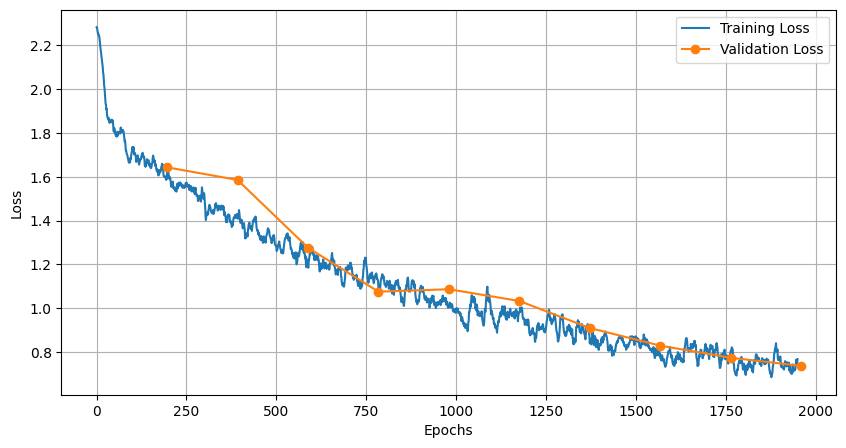

In [65]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses,epochs = epochs)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

width_multipliers = [x / 10 for x in range(1, 11)]

for width_multiplier in width_multipliers:
    model = MobileNetV2(n_class=10, width_multiplier=width_multiplier)

    num_params = count_parameters(model)

    print(f"with {width_multiplier} Width multiplier we got {num_params} parameters")


with 0.1 Width multiplier we got 31255 parameters
with 0.2 Width multiplier we got 105224 parameters
with 0.3 Width multiplier we got 221676 parameters
with 0.4 Width multiplier we got 380438 parameters
with 0.5 Width multiplier we got 587178 parameters
with 0.6 Width multiplier we got 826943 parameters
with 0.7 Width multiplier we got 1113168 parameters
with 0.8 Width multiplier we got 1441788 parameters
with 0.9 Width multiplier we got 1812806 parameters
with 1.0 Width multiplier we got 2236682 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [68]:
model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)  # Match the width_multiplier of the pre-trained model

pretrained_dict = torch.load('/kaggle/input/2/pytorch/default/1/MNv2WMmodel.pt', map_location=device)

model.load_state_dict(pretrained_dict)

/tmp/ipykernel_23/1727101108.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('/kaggle/input/2/pytorch/default/1/MNv2WMmodel.pt', map_locatio

<All keys matched successfully>

In [69]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



Val accuracy = 0.7432
Process validation time: 19.8524 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

1. **Width Multiplier and Parameters:**
   The width multiplier scales the number of channels in each layer, which in turn scales the number of parameters. The total number of parameters is roughly proportional to 𝛼^2, 𝛼 is the width multiplier. So, if 𝛼 is halved, the number of parameters will roughly decrease by a factor of 4. Discrepancies with the actual values may be due to architectural optimizations or skip connections.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

The resolution multiplier can make the model faster by reducing the input image size, which decreases computation time. However, it does not reduce the number of parameters, as those depend on the width multiplier and layer design. A smaller resolution can lead to faster inference but may reduce accuracy.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

The number of parameters impacts memory usage, training time, and inference time. Even with GPUs, more parameters mean higher memory consumption and slower processing. Optimizing the number of parameters remains crucial for efficiency, especially on resource-constrained devices.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [62]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

In [63]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 0.0904
Process validation time: 27.5144 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [66]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion_ce = nn.CrossEntropyLoss()

    def forward(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        soft_teacher_probs = torch.nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        soft_student_probs = torch.nn.functional.softmax(student_logits / self.temperature, dim=1)
        distillation_loss = nn.KLDivLoss(reduction='batchmean')(torch.log(soft_student_probs), soft_teacher_probs)
        classification_loss = self.criterion_ce(student_logits, labels)
        return self.alpha * distillation_loss + (1 - self.alpha) * classification_loss

def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            student_logits = student(inputs)
            teacher_logits = teacher(inputs)

            loss = criterion(student_logits, teacher_logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

        student.eval()
        val_acc = get_acc(student, test_loader)
        print(f'Validation Accuracy: {val_acc}')

teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

student_model = MobileNetV2(n_class=10, width_multiplier=1.0)

Train it for one epoch to just check if it works.

In [67]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [1/1], Loss: 0.8757320149820678
Validation Accuracy: 0.4777


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


A high value of alpha (e.g., 0.9) places more emphasis on the teacher's knowledge (distillation loss), leading the student model to closely mimic the teacher’s predictions, which can improve alignment with the teacher’s behavior but may reduce the student's ability to learn from the ground truth data. This could result in overfitting to the teacher's knowledge and limit generalization.

A low value of alpha (e.g., 0.1) gives more weight to the classification loss, allowing the student to focus more on the actual task and potentially improving its ability to generalize. However, this reduces the benefit of distillation, causing the student model to diverge from the teacher’s learned features, which might decrease the performance alignment with the teacher.

In summary, a high alpha favors teacher knowledge replication but may harm generalization, while a low alpha encourages task-specific learning at the cost of potentially losing the teacher's performance insights.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018